In [1]:
import pandas as pd
PATH = '/home/kai/data/kaggle/homecredit/'
train_missing = pd.read_pickle(PATH + 'feature_selection/missing.pkl')
ig = train_missing[train_missing > 0.8].index.values.tolist()

In [1]:
import sys
import time

class Logger(object):
    def __init__(self, logtofile=True, logfilename='log'):
        self.terminal = sys.stdout
        self.logfile = "{}_{}.log".format(logfilename, int(time.time()))
        self.logtofile = logtofile
    def write(self, message):
        if self.logtofile:
            self.log = open(self.logfile, "a")
            self.log.write(message)  
            self.log.close()
    def flush(self):
        pass
sys.stdout = Logger(logfilename='logfilecopy')

In [2]:
import pandas as pd
import numpy as np
import warnings
import time
warnings.filterwarnings("ignore")
import lightgbm as lgb
from bayes_opt import BayesianOptimization
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle

PATH = '/home/kai/data/kaggle/homecredit/'
train = pd.read_pickle(PATH + 'train_bo2.pkl')
test = pd.read_pickle(PATH + 'test_bo2.pkl')

pos = train[train.TARGET==1]
neg = train[train.TARGET==0]

train = pd.concat(shuffle([pos.sample(frac=0.1), neg.sample(frac=0.1)]), ignore_index=True)

ignored_col = ['ORGANIZATION_TYPE', 'TARGET', 'SK_ID_CURR']
feats = [x for x in train.columns if x not in ignored_col]

train.shape

(30751, 2678)

In [3]:
categorical_feats = [x for x in ['FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_TYPE_SUITE','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS',
'NAME_HOUSING_TYPE',
'OCCUPATION_TYPE','FLAG_DOCUMENT_2','FLAG_DOCUMENT_3','FLAG_DOCUMENT_4','FLAG_DOCUMENT_5','FLAG_DOCUMENT_6','FLAG_DOCUMENT_7','FLAG_DOCUMENT_8','FLAG_DOCUMENT_9','FLAG_DOCUMENT_10','FLAG_DOCUMENT_11','FLAG_DOCUMENT_12',
'FLAG_DOCUMENT_13','FLAG_DOCUMENT_14','FLAG_DOCUMENT_15','FLAG_DOCUMENT_16','FLAG_DOCUMENT_17','FLAG_DOCUMENT_18',
'FLAG_DOCUMENT_19','FLAG_DOCUMENT_20','FLAG_DOCUMENT_21',
'NAME_TYPE_SUITE'] if x not in ignored_col]

In [5]:
warnings.simplefilter(action='ignore', category=FutureWarning)
PATH = '/home/kai/data/kaggle/homecredit/'
print('begin cv')
target = train['TARGET']
test_df = test.copy()
ignore_cols = ['ORGANIZATION_TYPE', 'TARGET', 'SK_ID_CURR', 'DAYS_BIRTH']
features = [x for x in train.columns if x not in ignore_cols]
train = train[features]
test = test[features]

from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
import lightgbm as lgbm

lgbm_train = lgbm.Dataset(data=train,
                          label=target,
                          categorical_feature=categorical_feats,
                          free_raw_data=False)

lgbm_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.01,
    'num_iteration': 10000,
    'num_threads': 8,
    'num_leaves': int(round(59.960006)),
    'feature_fraction': 0.162771,
    'bagging_fraction': 0.863025,
    'max_depth': int(round(8.926612)),
    'lambda_l1': 0.124696,
    'lambda_l2': 0.213915,
    'min_split_gain': 0.070922,
    'min_child_weight': 45.939472,
    'early_stopping_rounds': 293.196657,
    'scale_pos_weight': 1.046659}

cv_results = lgbm.cv(train_set=lgbm_train,
                     params=lgbm_params,
                     nfold=5,
                     verbose_eval=100,
                     seed=1992,
                     metrics=['auc'])

optimum_boost_rounds = np.argmax(cv_results['auc-mean'])
print('Optimum boost rounds = {}'.format(optimum_boost_rounds))
print('Best CV result = {}'.format(np.max(cv_results['auc-mean'])))

clf = lgbm.train(train_set=lgbm_train,
                 params=lgbm_params,
                 num_boost_round=optimum_boost_rounds,
                verbose_eval=100)

""" Predict on test set and create submission """
y_pred = clf.predict(test)
out_df = pd.DataFrame({'SK_ID_CURR': test_df['SK_ID_CURR'], 'TARGET': y_pred})
print((out_df['TARGET']>0.5).sum(),'more than half')


In [ ]:
import matplotlib.pyplot as plt
out_df[['TARGET']].hist()
plt.show()

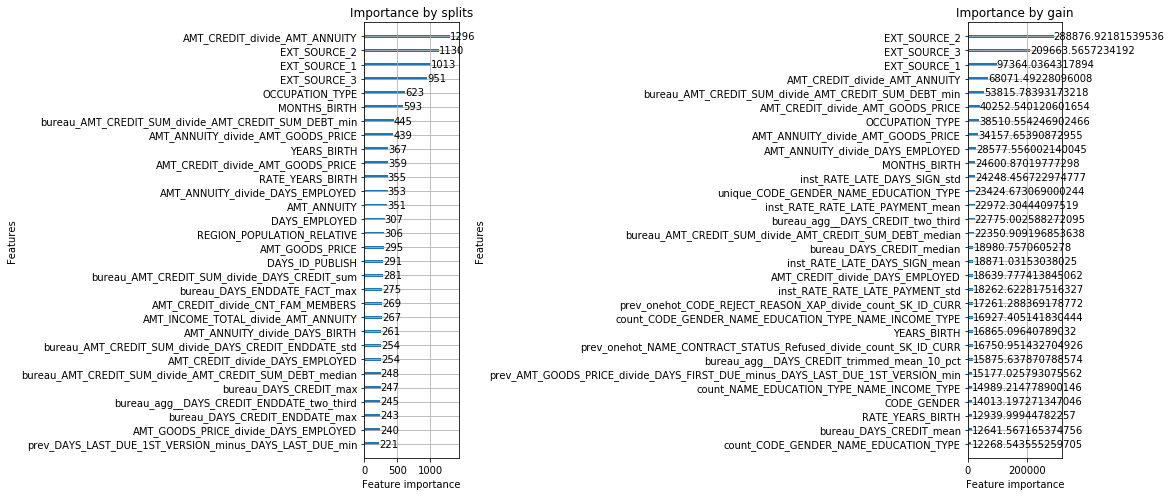

In [10]:
import matplotlib.pyplot as plt
import pickle

fig, (ax, ax1) = plt.subplots(1, 2, figsize=[15, 7])
lgbm.plot_importance(clf, ax=ax, max_num_features=30, importance_type='split')
lgbm.plot_importance(clf, ax=ax1, max_num_features=30, importance_type='gain')
ax.set_title('Importance by splits')
ax1.set_title('Importance by gain')
plt.tight_layout()
plt.show()

In [20]:
y = [x for x in zip(clf.feature_name(), clf.feature_importance('gain'))]
y.sort(key=lambda x: x[1], reverse=True)
y = [(i, j) for i, j in enumerate(y)]
# y.to_pickle(PATH + 'feature_importance_gain.pkl')
with open(PATH + 'feature_importance_gain.pkl', "wb") as f:
    pickle.dump(y, f)

In [21]:
x = [x for x in zip(clf.feature_name(), clf.feature_importance('split'))]
x.sort(key=lambda x: x[1], reverse=True)
x = [(i, j) for i, j in enumerate(x)]
# x.to_pickle(PATH + 'feature_importance_split.pkl')
with open(PATH + 'feature_importance_split.pkl', "wb") as f:
    pickle.dump(y, f)

In [23]:
y

[(0, ('EXT_SOURCE_2', 288876.92181539536)),
 (1, ('EXT_SOURCE_3', 209663.5657234192)),
 (2, ('EXT_SOURCE_1', 97364.0364317894)),
 (3, ('AMT_CREDIT_divide_AMT_ANNUITY', 68071.49228096008)),
 (4,
  ('bureau_AMT_CREDIT_SUM_divide_AMT_CREDIT_SUM_DEBT_min', 53815.78393173218)),
 (5, ('AMT_CREDIT_divide_AMT_GOODS_PRICE', 40252.540120601654)),
 (6, ('OCCUPATION_TYPE', 38510.554246902466)),
 (7, ('AMT_ANNUITY_divide_AMT_GOODS_PRICE', 34157.65390872955)),
 (8, ('AMT_ANNUITY_divide_DAYS_EMPLOYED', 28577.556002140045)),
 (9, ('MONTHS_BIRTH', 24600.87019777298)),
 (10, ('inst_RATE_LATE_DAYS_SIGN_std', 24248.456722974777)),
 (11, ('unique_CODE_GENDER_NAME_EDUCATION_TYPE', 23424.673069000244)),
 (12, ('inst_RATE_RATE_LATE_PAYMENT_mean', 22972.30444097519)),
 (13, ('bureau_agg__DAYS_CREDIT_two_third', 22775.002588272095)),
 (14,
  ('bureau_AMT_CREDIT_SUM_divide_AMT_CREDIT_SUM_DEBT_median',
   22350.909196853638)),
 (15, ('bureau_DAYS_CREDIT_median', 18980.7570605278)),
 (16, ('inst_RATE_LATE_DAYS_SIG

In [25]:
z = [a for a in y if a[1][1] == 0]
z

[(2365, ('REG_REGION_NOT_LIVE_REGION', 0.0)),
 (2366, ('LIVE_REGION_NOT_WORK_REGION', 0.0)),
 (2367, ('FLAG_DOCUMENT_2', 0.0)),
 (2368, ('FLAG_DOCUMENT_4', 0.0)),
 (2369, ('FLAG_DOCUMENT_5', 0.0)),
 (2370, ('FLAG_DOCUMENT_7', 0.0)),
 (2371, ('FLAG_DOCUMENT_9', 0.0)),
 (2372, ('FLAG_DOCUMENT_10', 0.0)),
 (2373, ('FLAG_DOCUMENT_11', 0.0)),
 (2374, ('FLAG_DOCUMENT_12', 0.0)),
 (2375, ('FLAG_DOCUMENT_14', 0.0)),
 (2376, ('FLAG_DOCUMENT_15', 0.0)),
 (2377, ('FLAG_DOCUMENT_17', 0.0)),
 (2378, ('FLAG_DOCUMENT_19', 0.0)),
 (2379, ('FLAG_DOCUMENT_20', 0.0)),
 (2380, ('FLAG_DOCUMENT_21', 0.0)),
 (2381, ('AMT_REQ_CREDIT_BUREAU_HOUR', 0.0)),
 (2382, ('AMT_REQ_CREDIT_BUREAU_DAY', 0.0)),
 (2383, ('AMT_REQ_CREDIT_BUREAU_WEEK', 0.0)),
 (2384, ('AMT_INCOME_TOTAL_divide_AMT_REQ_CREDIT_BUREAU_HOUR', 0.0)),
 (2385, ('AMT_CREDIT_divide_AMT_REQ_CREDIT_BUREAU_HOUR', 0.0)),
 (2386, ('AMT_GOODS_PRICE_divide_AMT_REQ_CREDIT_BUREAU_HOUR', 0.0)),
 (2387, ('AMT_GOODS_PRICE_divide_AMT_REQ_CREDIT_BUREAU_WEEK', 0.0)),